Combine multiple adapters to create new and unique images.

In [1]:
!pip install -q "transformers==4.45.1" "accelerate==0.34.2" "peft==0.13.0" "diffusers==0.30.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 70.9 MB/s eta 0:00:00


In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

In [3]:
# add toy adapter using load_lora_weights()
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

toy_face_sdxl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

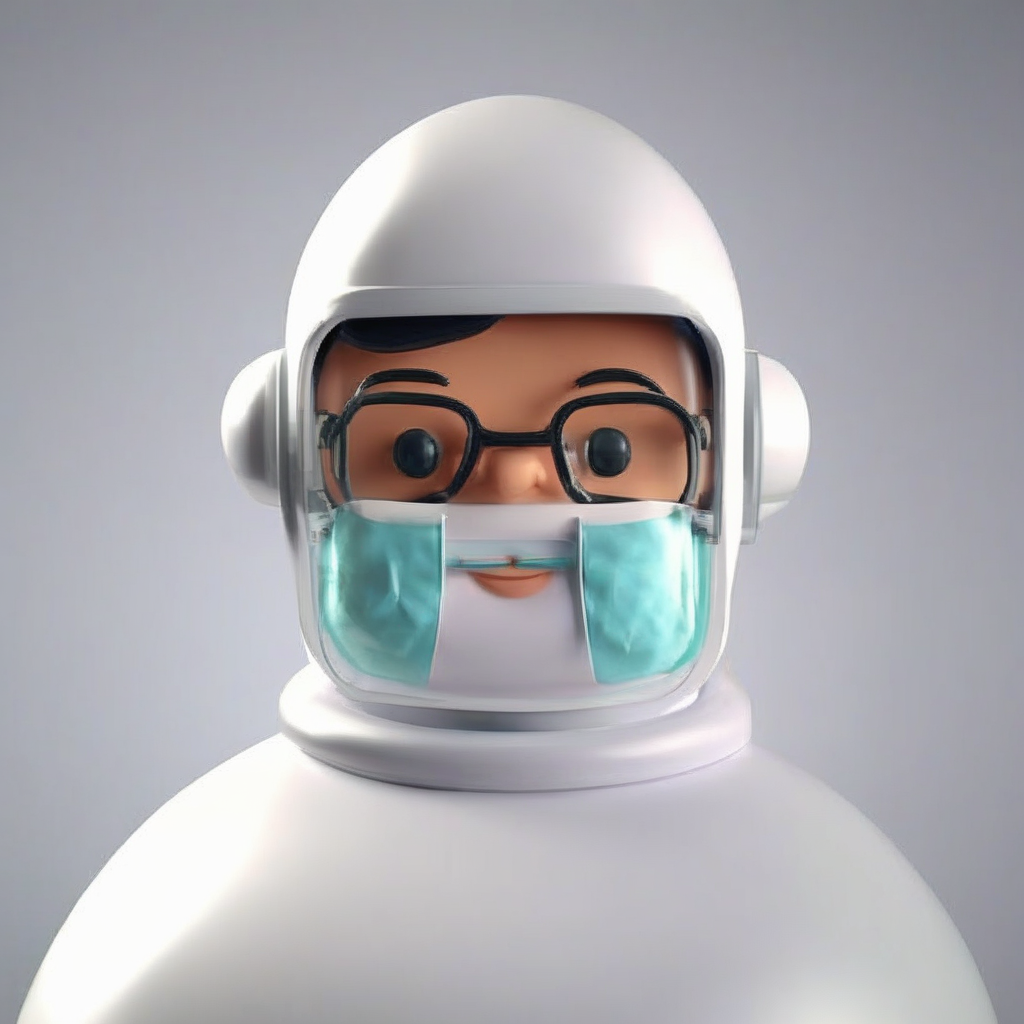

In [4]:
prompt = "toy_face of a scientist wearing a safety suit"

lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

# activate second adapter

The pipeline automatically sets the first loaded adapter ("**toy**") as the active adapter, but you can activate the "**pixel**" adapter with the **set_adapters** method

In [5]:
# add another adapter ("pixel")
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

pixel-art-xl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

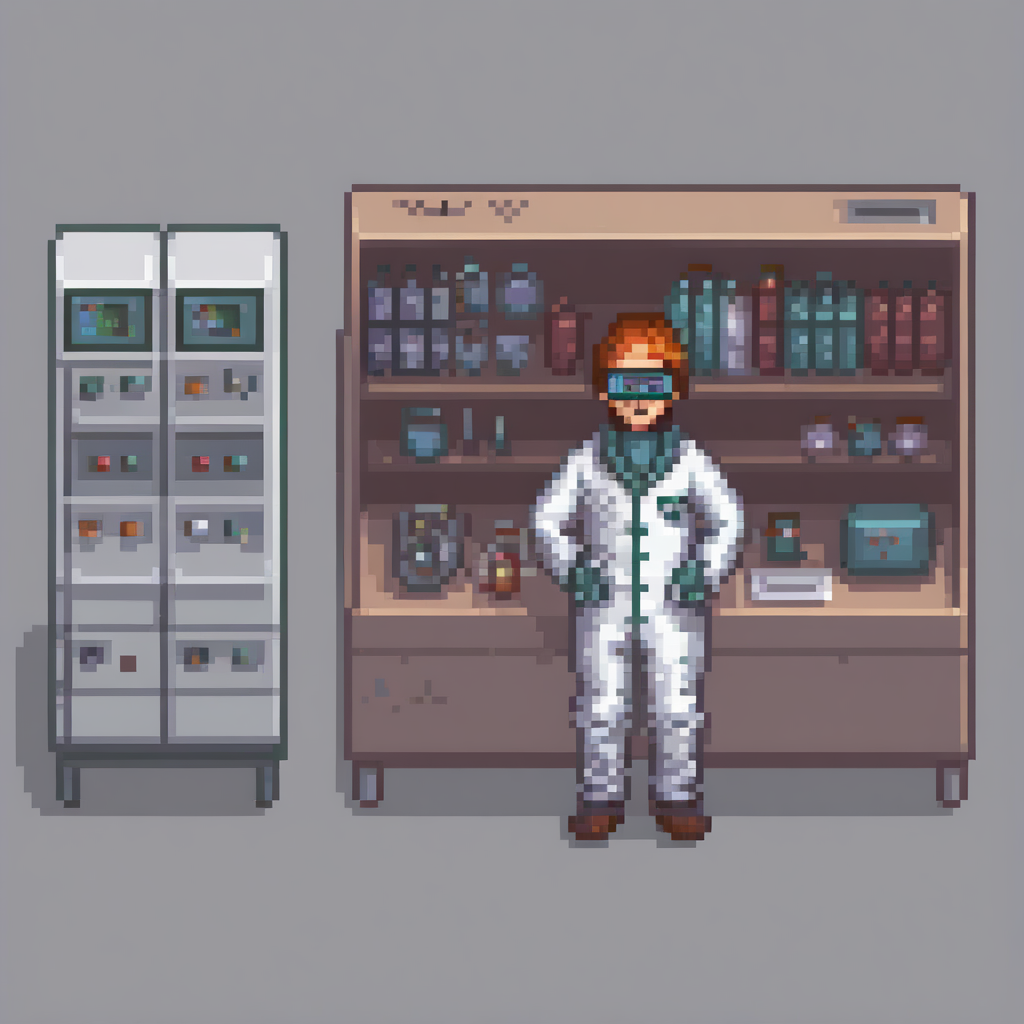

In [6]:
prompt = "a scientist wearing a safety suit, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

# Merge adapters

In [7]:
# activate the pixel and toy adapters
pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

  0%|          | 0/30 [00:00<?, ?it/s]

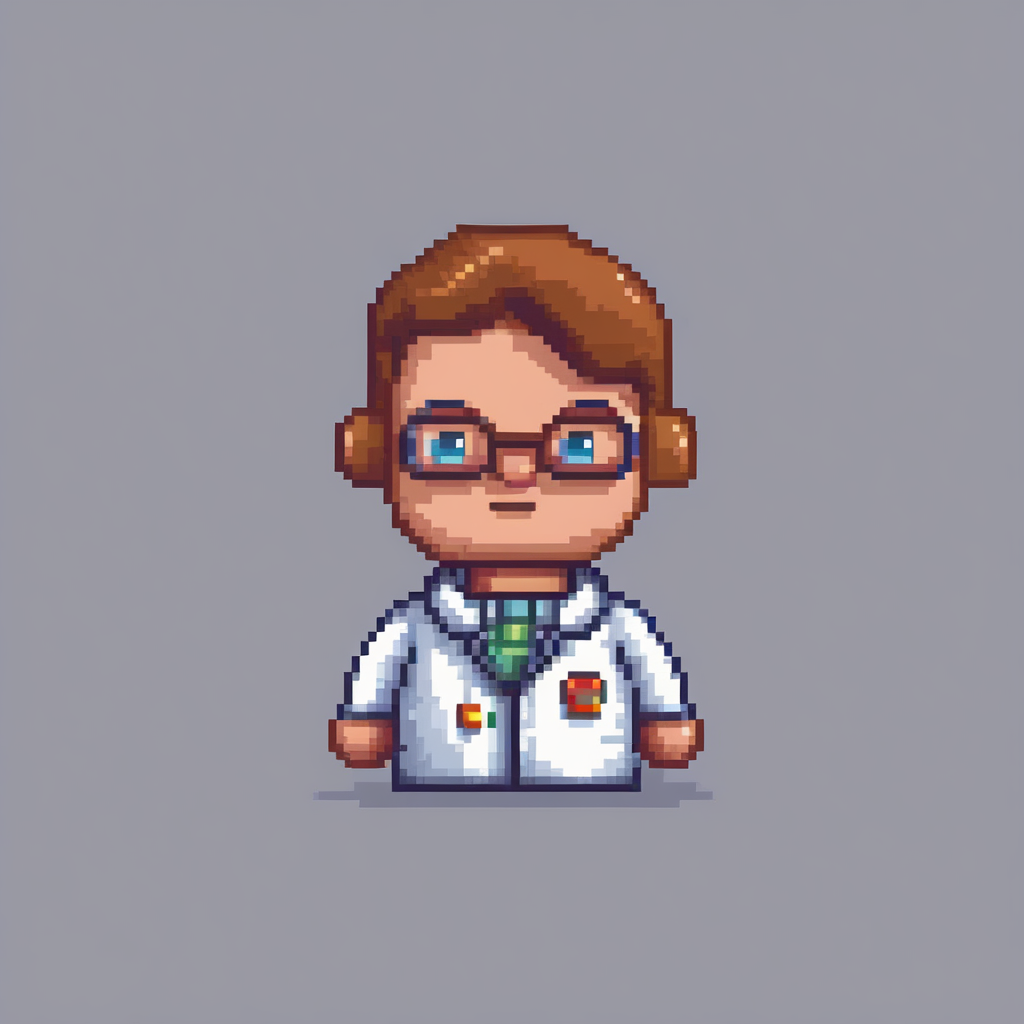

In [8]:
prompt = "toy_face of a scientist wearing a safety suit, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]
image

# Use only toy adapter

In [ ]:
pipe.set_adapters("toy")

prompt = "toy_face of a scientist wearing a safety suit"
lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

# Disable all adapters

  0%|          | 0/30 [00:00<?, ?it/s]

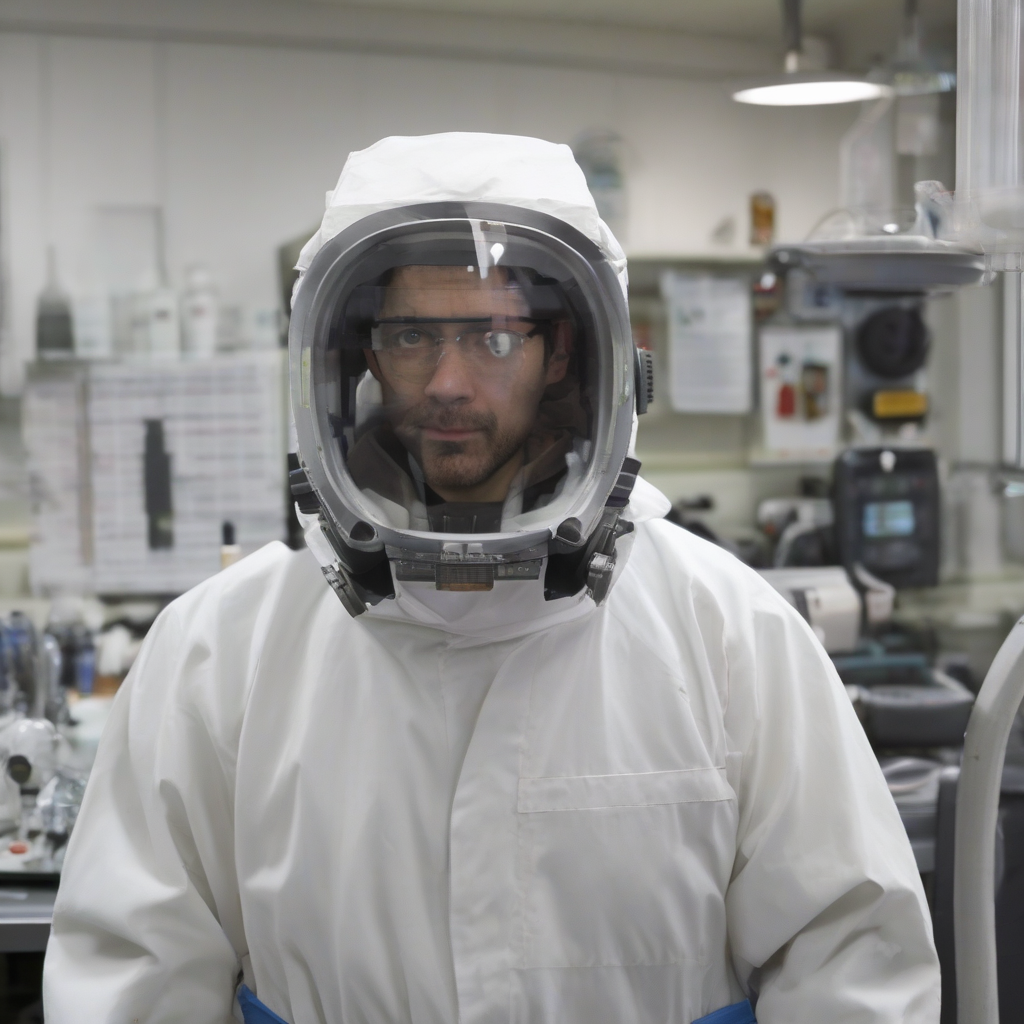

In [10]:
pipe.disable_lora()

prompt = "a scientist wearing a safety suit"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

# Customize adapters
Control how strongly the adapter affects each part of the pipeline.
Here, pass a dictionary with the control strengths (called **scales**)

  0%|          | 0/30 [00:00<?, ?it/s]

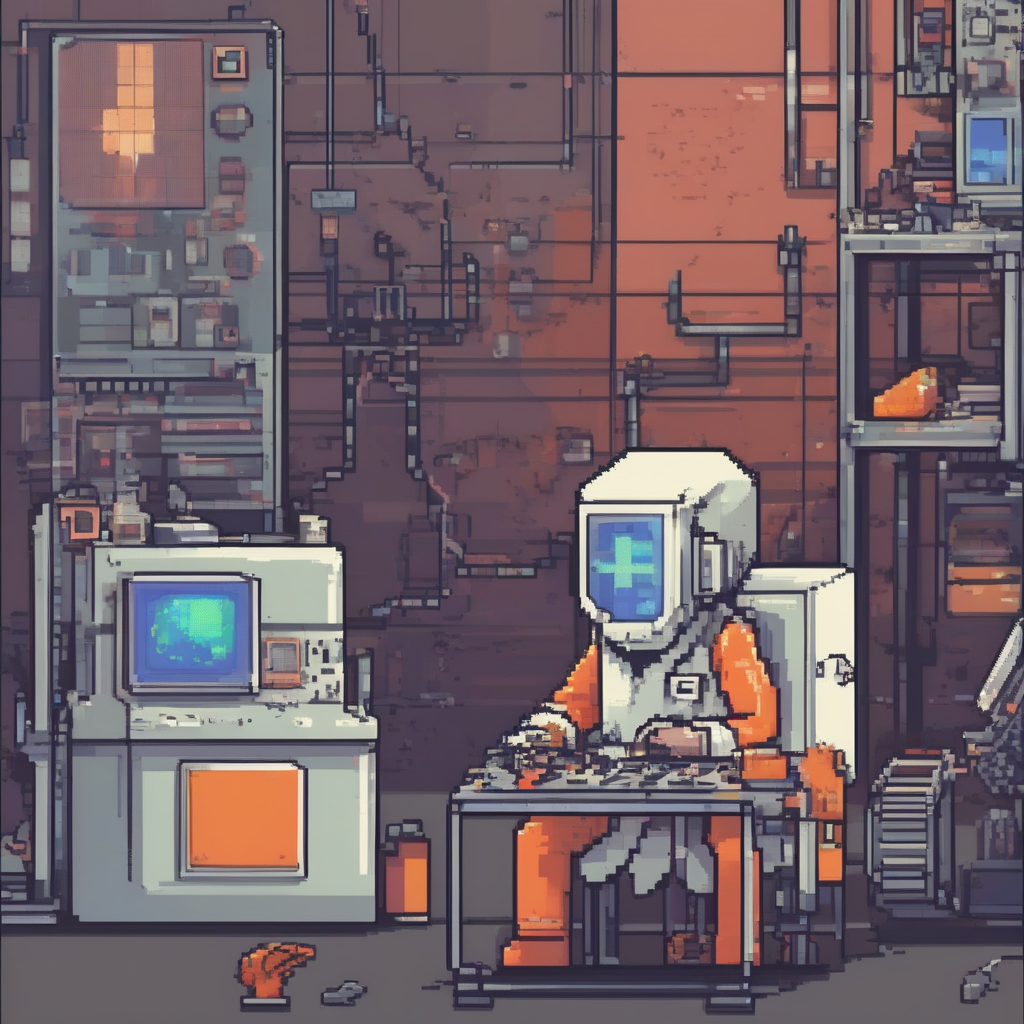

In [11]:
pipe.enable_lora()  # enable lora again, after we disabled it above

prompt = "a scientist wearing a safety suit, pixel art"

# turning off the down part and turning on the mid and up part
adapter_weight_scales = { "unet": { "down": 0, "mid": 1, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)

image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image